<a href="https://colab.research.google.com/github/Jarin160/Smart-Waste-Classification-System/blob/main/waste_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
!unzip split_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: split_dataset/train/shoes/shoes_515.jpg  
  inflating: split_dataset/train/shoes/shoes_518.jpg  
  inflating: split_dataset/train/shoes/shoes_519.jpg  
  inflating: split_dataset/train/shoes/shoes_52.jpg  
  inflating: split_dataset/train/shoes/shoes_520.jpg  
  inflating: split_dataset/train/shoes/shoes_521.jpg  
  inflating: split_dataset/train/shoes/shoes_522.jpg  
  inflating: split_dataset/train/shoes/shoes_523.jpg  
  inflating: split_dataset/train/shoes/shoes_526.jpg  
  inflating: split_dataset/train/shoes/shoes_528.jpg  
  inflating: split_dataset/train/shoes/shoes_530.jpg  
  inflating: split_dataset/train/shoes/shoes_531.jpg  
  inflating: split_dataset/train/shoes/shoes_535.jpg  
  inflating: split_dataset/train/shoes/shoes_537.jpg  
  inflating: split_dataset/train/shoes/shoes_538.jpg  
  inflating: split_dataset/train/shoes/shoes_539.jpg  
  inflating: split_dataset/train/shoes/shoes_54.jpg  
  inflating: spl

In [19]:
img_size = (224,224)
batch_size = 32
SEED = 42

train_path = 'split_dataset/train'
val_path = 'split_dataset/val'
test_path = 'split_dataset/test'

cls_names = os.listdir(train_path)
print(cls_names)

['paper', 'glass', 'clothes', 'shoes', 'trash', 'battery', 'cardboard', 'plastic', 'metal', 'biological']


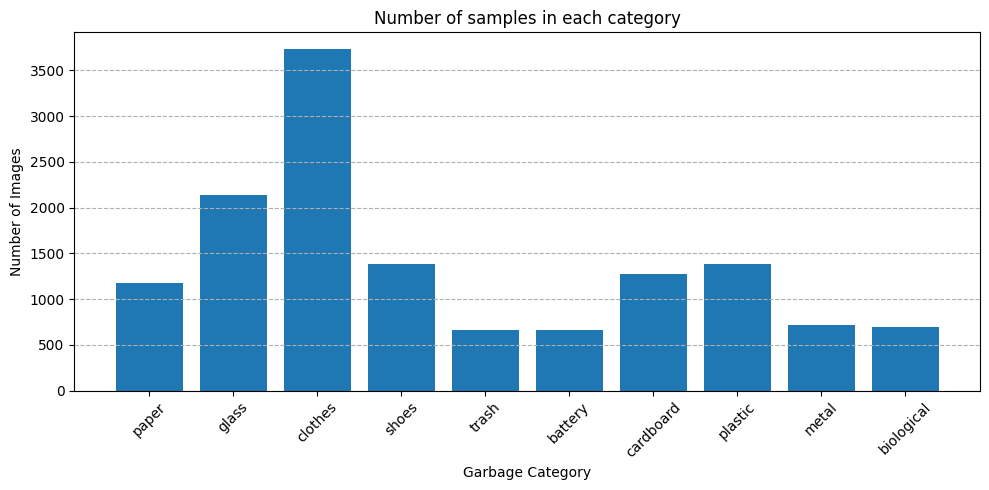

In [5]:
class_counts = { category: len(os.listdir(os.path.join(train_path, category))) for category in cls_names }

plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=45)
plt.title("Number of samples in each category")
plt.xlabel("Garbage Category")
plt.ylabel("Number of Images")
plt.grid(axis="y", linestyle="--")
plt.tight_layout()
plt.show()

In [6]:
def check_bad_images(base_path):
    bad_images = []


    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith(('jpg', 'jpeg', 'png')):
                try:
                    img = Image.open(os.path.join(root, file))
                    img.verify()  # Will raise an exception if the image is corrupted
                except:
                    bad_images.append(os.path.join(root, file))

    print("Bad images:", bad_images)

check_bad_images(train_path)
check_bad_images(val_path)

Bad images: []
Bad images: []


In [7]:
def get_train_test(train_path, val_path, test_path, img_size = img_size, batch_size = batch_size, seed= SEED):

  train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        brightness_range=[0.9, 1.1],
        horizontal_flip=True,
        fill_mode='nearest'
    )

  val_test_datagen = ImageDataGenerator(
      rescale=1./255
  )

  train_data = train_datagen.flow_from_directory(
      train_path,
      target_size=img_size,
      batch_size=batch_size,
      class_mode='categorical',
      shuffle=True,
      seed=seed
  )

  val_data = val_test_datagen.flow_from_directory(
      val_path,
      target_size=img_size,
      batch_size=batch_size,
      class_mode='categorical',
      shuffle=False
  )

  test_data = val_test_datagen.flow_from_directory(
      test_path,
      target_size=img_size,
      batch_size=batch_size,
      class_mode='categorical',
      shuffle=False
  )

  return train_data, val_data, test_data

train_data, val_data, test_data = get_train_test(train_path, val_path,test_path)

Found 13827 images belonging to 10 classes.
Found 3949 images belonging to 10 classes.
Found 1986 images belonging to 10 classes.


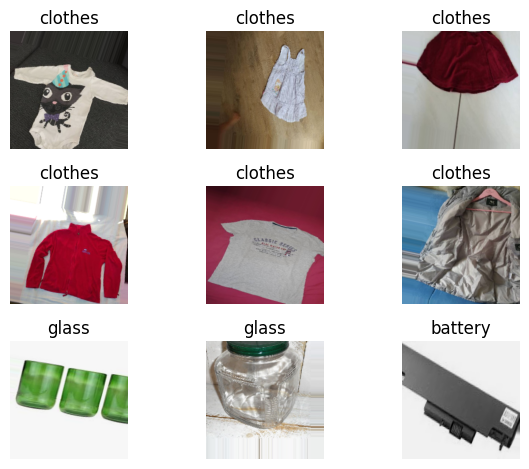

In [8]:
for i in range(min(len(train_data[0][0]), 9)):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(train_data[0][0][i])

    class_names = list(train_data.class_indices.keys())
    plt.title(class_names[np.argmax(train_data[0][1][i])])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [9]:
base_model = ResNet101V2(weights='imagenet', include_top=False, input_shape=(224,224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)

output = layers.Dense(10, activation='softmax')(x)
model= models.Model(inputs=base_model.input, outputs=output)

model.summary()

171317808/171317808 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 42,890,122 (163.61 MB)

 Trainable params: 263,562 (1.01 MB)

 Non-trainable params: 42,626,560 (162.61 MB)

In [10]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

callbacks = [
        early_stopping,
        reduce_lr
    ]

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    batch_size = batch_size,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 270s 576ms/step - accuracy: 0.6512 - loss: 1.1308 - val_accuracy: 0.8985 - val_loss: 0.3421 - learning_rate: 1.0000e-04
Epoch 2/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 230s 530ms/step - accuracy: 0.8799 - loss: 0.3749 - val_accuracy: 0.9096 - val_loss: 0.2838 - learning_rate: 1.0000e-04
Epoch 3/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 232s 534ms/step - accuracy: 0.9028 - loss: 0.3067 - val_accuracy: 0.9182 - val_loss: 0.2599 - learning_rate: 1.0000e-04
Epoch 4/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 232s 534ms/step - accuracy: 0.9205 - loss: 0.2511 - val_accuracy: 0.9233 - val_loss: 0.2395 - learning_rate: 1.0000e-04
Epoch 5/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 230s 531ms/step - accuracy: 0.9240 - loss: 0.2287 - val_accuracy: 0.9293 - val_loss: 0.2315 - learning_rate: 1.0000e-04
Epoch 6/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 231s 534ms/step - accuracy: 0.9337 - loss: 0.2109 - val_accuracy: 0.9288 - val_loss: 0.2243 - learning_rate: 1.0000e-04
Epoch 7/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 

In [16]:
test_loss, test_acc = model.evaluate(test_data, verbose=1)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 248ms/step - accuracy: 0.9523 - loss: 0.1460
Test Accuracy: 94.36%
Test Loss: 0.1652


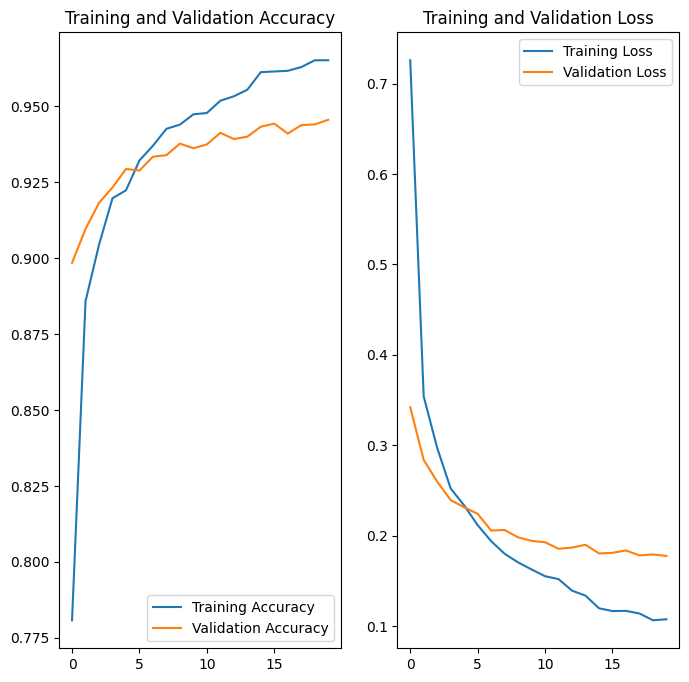

In [23]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(20), accuracy, label = 'Training Accuracy')
plt.plot(range(20), val_accuracy, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(20), loss, label = 'Training Loss')
plt.plot(range(20), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


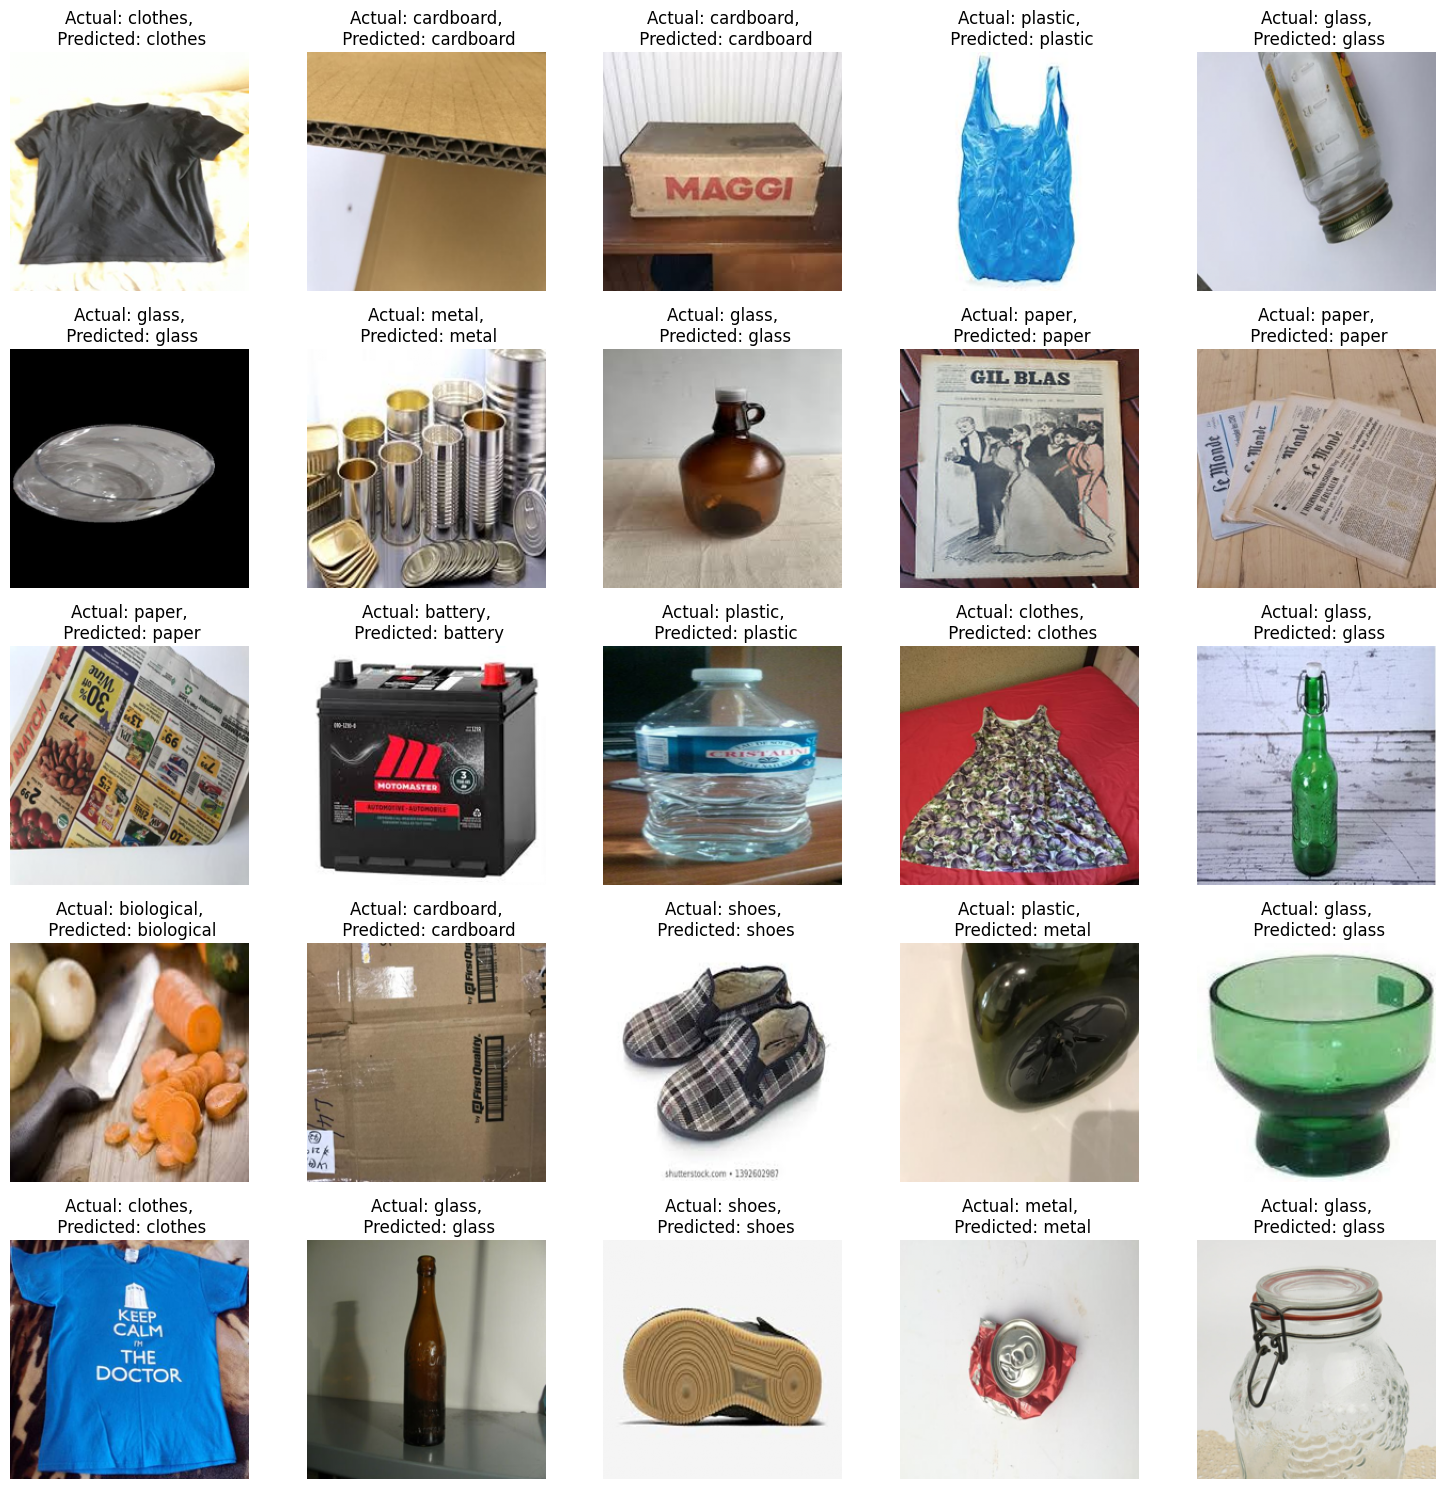

In [29]:
def predict(model, img_array):
    # Ensure the image array has the correct shape for the model (batch_size, height, width, channels)
    img_array = np.expand_dims(img_array, axis=0)
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0]) # Get predictions for the single image in the batch
    predicted_class_index = np.argmax(score)
    predicted_class_name = class_names[predicted_class_index]
    return predicted_class_name

plt.figure(figsize=(15,15)) # Increased figure size
num_images_to_show = 25 # Increased number of images to show

# Get list of all files in the test directory
all_test_files = [os.path.join(root, file) for root, dirs, files in os.walk(test_path) for file in files if file.lower().endswith(('jpg', 'jpeg', 'png'))]

# Select random indices from the list of all test files
random_indices = np.random.choice(len(all_test_files), size=num_images_to_show, replace=False)

for i, idx in enumerate(random_indices):
    img_path = all_test_files[idx]
    img = Image.open(img_path).convert('RGB') # Convert image to RGB
    img_array = np.array(img.resize(img_size)) / 255.0 # Resize and normalize

    # Determine the actual class from the directory name
    actual_cls = os.path.basename(os.path.dirname(img_path))

    ax = plt.subplot(5, 5, i+1) # Adjusted subplot grid
    plt.imshow(img_array)

    predicted_cls= predict(model, img_array)

    plt.axis("off")
    plt.title(f"Actual: {actual_cls},\n Predicted: {predicted_cls}")

plt.tight_layout()
plt.show()

In [ ]:
model.save('waste_classification_model.h5')